In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

In [59]:
odds = pd.read_excel('data/nhl odds 2021.xlsx')

In [60]:
odds.head()

,Date,Rot,VH,Team,1st,2nd,3rd,Final,Open,Close,PuckLine,Unnamed: 11,OpenOU,Unnamed: 13,CloseOU,Unnamed: 15
0,113,41,V,Pittsburgh,1,1,1,3,-110,-115,1.5,-310,6.0,-110,6.0,105
1,113,42,H,Philadelphia,2,1,3,6,100,-105,-1.5,260,6.0,-110,6.0,-125
2,113,43,V,Montreal,2,1,1,0,132,120,1.5,-220,6.0,-110,6.0,-110
3,113,44,H,Toronto,1,2,1,1,-145,-140,-1.5,195,6.0,-110,6.0,-110
4,113,45,V,Chicago,0,0,1,1,230,210,1.5,-125,6.5,-110,6.5,-110


In [61]:
team_conversion =   { 'Anaheim': 'ANA', 
                      'Arizona' :'ARI', 
                      'Boston': 'BOS', 
                      'Buffalo':'BUF',
                      'Calgary': 'CGY', 
                      'Carolina': 'CAR', 
                      'Chicago': 'CHI', 
                      'Colorado': 'COL',
                     'Columbus': 'CBJ',
                     'Dallas': 'DAL',
                     'Detroit': 'DET',
                     'Edmonton': 'EDM',
                     'Florida': 'FLA',
                     'LosAngeles': 'L.A',
                     'Minnesota': 'MIN',
                     'Montreal': 'MTL',
                     'Nashville': 'NSH',
                     'NewJersey': 'N.J',
                     'NYIslanders': 'NYI',
                     'NYRangers': 'NYR',
                     'Ottawa': 'OTT',
                     'Philadelphia': 'PHI',
                     'Pittsburgh': 'PIT',
                     'SanJose': 'S.J',
                     'St.Louis': 'STL',
                     'TampaBay': 'T.B',
                     'Toronto': 'TOR',
                     'Vancouver': 'VAN',
                      'Vegas':'VGK',
                     'Washington': 'WSH',
                     'Winnipeg': 'WPG'}

In [62]:
odds = odds.replace({'Team': team_conversion})

In [83]:
odds['Month'] = odds['Date'].apply(lambda x: '0'+str(x)[0])
odds['Day'] = odds['Date'].apply(lambda x: str(x)[1:])
odds['Year'] = 2021

In [84]:
odds.head(10)

,Date,Rot,VH,Team,1st,2nd,3rd,Final,Open,Close,PuckLine,Unnamed: 11,OpenOU,Unnamed: 13,CloseOU,Unnamed: 15,Month,Day,Year,Datetime,Team_Key,Implied_odds,Datestring
0,113,41,V,PIT,1,1,1,3,-110,-115,1.5,-310,6.0,-110,6.0,105,01,13,2021,2021-01-13,PIT_2021-01-13,0.534884,2021-1-13
1,113,42,H,PHI,2,1,3,6,100,-105,-1.5,260,6.0,-110,6.0,-125,01,13,2021,2021-01-13,PHI_2021-01-13,0.512195,2021-1-13
2,113,43,V,MTL,2,1,1,0,132,120,1.5,-220,6.0,-110,6.0,-110,01,13,2021,2021-01-13,MTL_2021-01-13,0.454545,2021-1-13
3,113,44,H,TOR,1,2,1,1,-145,-140,-1.5,195,6.0,-110,6.0,-110,01,13,2021,2021-01-13,TOR_2021-01-13,0.583333,2021-1-13
4,113,45,V,CHI,0,0,1,1,230,210,1.5,-125,6.5,-110,6.5,-110,01,13,2021,2021-01-13,CHI_2021-01-13,0.322581,2021-1-13
5,113,46,H,T.B,3,1,1,5,-260,-250,-1.5,105,6.5,-110,6.5,-110,01,13,2021,2021-01-13,T.B_2021-01-13,0.714286,2021-1-13
6,113,47,V,VAN,1,1,3,5,135,130,1.5,-215,5.5,-110,6.5,100,01,13,2021,2021-01-13,VAN_2021-01-13,0.434783,2021-1-13
7,113,48,H,EDM,0,1,2,3,-150,-150,-1.5,190,5.5,-110,6.5,-120,01,13,2021,2021-01-13,EDM_2021-01-13,0.600000,2021-1-13
8,113,49,V,STL,2,0,2,4,135,125,1.5,-200,5.5,-110,6.0,-110,01,13,2021,2021-01-13,STL_2021-01-13,0.444444,2021-1-13
9,113,50,H,COL,1,0,0,1,-150,-145,-1.5,175,5.5,-110,6.0,-110,01,13,2021,2021-01-13,COL_2021-01-13,0.591837,2021-1-13


In [87]:
odds['Datestring'] = odds[['Year','Month','Day']].astype(str).apply('-'.join, 1)
                

odds['Team_Key'] = odds['Team'].astype(str)+'_'+odds['Datestring'].astype(str)

In [67]:
odds['Implied_odds'] = np.where(odds['Close'] < 0, (odds['Close']*-1)/((odds['Close']*-1)+100) , 100/(odds['Close']+100))

In [111]:
predictions = pd.read_csv('data/Predictions_2021')

In [112]:
df = predictions.merge(odds.loc[:,['Team_Key', 'Implied_odds', 'Close']].add_prefix('home_'), how = 'left', left_on = 'Home_Team_Key', right_on = 'home_Team_Key').drop(columns = 'home_Team_Key')
df = df.merge(odds.loc[:,['Team_Key', 'Implied_odds', 'Close']].add_prefix('away_'), how = 'left', left_on = 'Away_Team_Key', right_on = 'away_Team_Key').drop(columns = 'away_Team_Key')

In [113]:
df.isna().sum()

Unnamed: 0                      0
game_id                         0
date                            0
venue                           0
home_team                       0
away_team                       0
start_time                      0
home_score                      0
away_score                      0
status                          0
Home_Team_Won                   0
Home_Team_Key                   0
Away_Team_Key                   0
home_Game_Number                0
away_Game_Number                0
home_goalie                     0
home_Goalie_FenwickSV%          0
home_Goalie_GSAx/60             0
home_Goalie_HDCSV%              0
away_goalie                     0
away_Goalie_FenwickSV%          0
away_Goalie_GSAx/60             0
away_Goalie_HDCSV%              0
home_last_40_FF%_5v5            0
home_last_40_GF%_5v5            0
home_last_40_xGF%_5v5           0
home_last_40_SH%                0
home_last40_pp_TOI_per_game     0
home_last40_xGF_per_min_pp      0
home_last40_GF

In [114]:
conditions = [df['Home Win Probability'] > df['home_Implied_odds'],
                df['Away Win Probability'] > df['away_Implied_odds']
                 ]
    

choices = ['Home', 
          'Away']

df['Bet'] = np.select(conditions, choices, default = 'No Bet')


In [115]:
df['Bet'].value_counts()

Home      455
Away      220
No Bet    145
Name: Bet, dtype: int64

In [220]:
df['Favorites'] = np.where(df['home_Implied_odds'] >df['away_Implied_odds'], 'Home', 'Away' )
df['Bet_For']

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet,Profit,Profit_Strat2,Cost_Strat2,Profit_Strat2_cumsum,Favorites
0,3626,2020020001,2021-01-13,Wells Fargo Center,PHI,PIT,2021-01-13 22:30:00,6,3,Final,1,PHI_2021-01-13,PIT_2021-01-13,1.0,1.0,Carter Hart,0.936798,-0.097290,0.869565,Tristan Jarry,0.937063,-0.291447,0.834711,51.037671,55.248131,50.833631,10.024139,5.216250,0.104625,0.134196,5.579583,0.088716,0.112016,49.490424,49.414366,49.580182,8.701463,5.068333,0.122230,0.143045,4.693750,0.094008,0.111851,1531.48,1514.01,Neither,1,0.438607,0.561393,0.512195,-105.0,0.534884,-115.0,Home,95.238095,100.0,105.0,100.0,Away
1,3627,2020020003,2021-01-13,Scotiabank Arena,TOR,MTL,2021-01-14 00:00:00,5,4,Final,1,TOR_2021-01-13,MTL_2021-01-13,1.0,1.0,Frederik Andersen,0.936070,-0.305563,0.866051,Carey Price,0.930668,-0.444146,0.862233,50.926333,51.613248,52.907871,9.385230,4.490833,0.102876,0.161440,4.251250,0.095972,0.117612,54.275967,49.447384,54.826724,6.807514,4.443333,0.093567,0.090023,5.106250,0.115594,0.112607,1516.52,1497.57,Neither,1,0.404786,0.595214,0.583333,-140.0,0.454545,120.0,Home,71.428571,100.0,140.0,200.0,Home
2,3628,2020020002,2021-01-13,Amalie Arena,T.B,CHI,2021-01-14 01:00:00,5,1,Final,1,T.B_2021-01-13,CHI_2021-01-13,1.0,1.0,Andrei Vasilevskiy,0.941531,-0.023160,0.876847,Malcolm Subban,0.923432,-0.589420,0.857809,53.085863,60.496256,55.396941,9.975409,5.086667,0.095347,0.098296,5.632500,0.101065,0.106525,49.003131,51.252598,47.514358,9.212376,5.646667,0.107010,0.084120,4.739583,0.103226,0.089670,1584.31,1492.13,Neither,1,0.320753,0.679246,0.714286,-250.0,0.322581,210.0,No Bet,0.000000,0.0,0.0,200.0,Home
3,3629,2020020004,2021-01-13,Rogers Place,EDM,VAN,2021-01-14 03:00:00,3,5,Final,0,EDM_2021-01-13,VAN_2021-01-13,1.0,1.0,Mikko Koskinen,0.938316,-0.009204,0.867299,Braden Holtby,0.927771,-0.408527,0.852194,48.540721,47.474864,48.384948,8.348491,4.868750,0.111322,0.154044,4.358333,0.114551,0.103250,47.274508,48.647099,46.039131,8.973817,5.262917,0.098805,0.128256,5.131250,0.110110,0.116931,1490.93,1510.30,Neither,1,0.418404,0.581596,0.600000,-150.0,0.434783,130.0,No Bet,0.000000,0.0,0.0,200.0,Home
4,3630,2020020005,2021-01-13,Ball Arena,COL,STL,2021-01-14 03:30:00,1,4,Final,0,COL_2021-01-13,STL_2021-01-13,1.0,1.0,Philipp Grubauer,0.938738,-0.054610,0.852300,Jordan Binnington,0.936047,-0.058439,0.891566,54.173584,55.777256,54.433969,8.037510,5.254167,0.107819,0.118953,4.904583,0.115045,0.091751,53.469034,58.414704,53.596844,8.848351,4.181250,0.128311,0.161435,4.751667,0.124851,0.142055,1549.43,1526.11,Neither,1,0.449294,0.550706,0.591837,-145.0,0.444444,125.0,Away,125.000000,100.0,80.0,300.0,Home


In [116]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet
0,3626,2020020001,2021-01-13,Wells Fargo Center,PHI,PIT,2021-01-13 22:30:00,6,3,Final,1,PHI_2021-01-13,PIT_2021-01-13,1.0,1.0,Carter Hart,0.936798,-0.097290,0.869565,Tristan Jarry,0.937063,-0.291447,0.834711,51.037671,55.248131,50.833631,10.024139,5.216250,0.104625,0.134196,5.579583,0.088716,0.112016,49.490424,49.414366,49.580182,8.701463,5.068333,0.122230,0.143045,4.693750,0.094008,0.111851,1531.48,1514.01,Neither,1,0.438607,0.561393,0.512195,-105.0,0.534884,-115.0,Home
1,3627,2020020003,2021-01-13,Scotiabank Arena,TOR,MTL,2021-01-14 00:00:00,5,4,Final,1,TOR_2021-01-13,MTL_2021-01-13,1.0,1.0,Frederik Andersen,0.936070,-0.305563,0.866051,Carey Price,0.930668,-0.444146,0.862233,50.926333,51.613248,52.907871,9.385230,4.490833,0.102876,0.161440,4.251250,0.095972,0.117612,54.275967,49.447384,54.826724,6.807514,4.443333,0.093567,0.090023,5.106250,0.115594,0.112607,1516.52,1497.57,Neither,1,0.404786,0.595214,0.583333,-140.0,0.454545,120.0,Home
2,3628,2020020002,2021-01-13,Amalie Arena,T.B,CHI,2021-01-14 01:00:00,5,1,Final,1,T.B_2021-01-13,CHI_2021-01-13,1.0,1.0,Andrei Vasilevskiy,0.941531,-0.023160,0.876847,Malcolm Subban,0.923432,-0.589420,0.857809,53.085863,60.496256,55.396941,9.975409,5.086667,0.095347,0.098296,5.632500,0.101065,0.106525,49.003131,51.252598,47.514358,9.212376,5.646667,0.107010,0.084120,4.739583,0.103226,0.089670,1584.31,1492.13,Neither,1,0.320753,0.679246,0.714286,-250.0,0.322581,210.0,No Bet
3,3629,2020020004,2021-01-13,Rogers Place,EDM,VAN,2021-01-14 03:00:00,3,5,Final,0,EDM_2021-01-13,VAN_2021-01-13,1.0,1.0,Mikko Koskinen,0.938316,-0.009204,0.867299,Braden Holtby,0.927771,-0.408527,0.852194,48.540721,47.474864,48.384948,8.348491,4.868750,0.111322,0.154044,4.358333,0.114551,0.103250,47.274508,48.647099,46.039131,8.973817,5.262917,0.098805,0.128256,5.131250,0.110110,0.116931,1490.93,1510.30,Neither,1,0.418404,0.581596,0.600000,-150.0,0.434783,130.0,No Bet
4,3630,2020020005,2021-01-13,Ball Arena,COL,STL,2021-01-14 03:30:00,1,4,Final,0,COL_2021-01-13,STL_2021-01-13,1.0,1.0,Philipp Grubauer,0.938738,-0.054610,0.852300,Jordan Binnington,0.936047,-0.058439,0.891566,54.173584,55.777256,54.433969,8.037510,5.254167,0.107819,0.118953,4.904583,0.115045,0.091751,53.469034,58.414704,53.596844,8.848351,4.181250,0.128311,0.161435,4.751667,0.124851,0.142055,1549.43,1526.11,Neither,1,0.449294,0.550706,0.591837,-145.0,0.444444,125.0,Away


In [124]:
conditions = [((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close'] <0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']<0)),
                ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']>0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [-100 * (100/df['home_Close']), 
           df['home_Close'],
          -100 * (100/df['away_Close']),
          df['away_Close'],
          0]

df['Profit'] = np.select(conditions, choices, default = -100)

In [169]:
conditions = [((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close'] <0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close']>0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 0) & (df['home_Close']>0)),
              ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 0) & (df['home_Close']<0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']<0)),
                ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 1) & (df['away_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 1) & (df['away_Close']<0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [100, 
           100,
          (100/df['home_Close'])*-100,
           df['home_Close'],
           100,
           100,
             (100/df['away_Close'])*-100,
          df['away_Close'],
          0]

df['Profit_Strat2'] = np.select(conditions, choices)

In [180]:
conditions = [((df['Bet'] == 'Home') & (df['home_Close']>0)),
              ((df['Bet'] == 'Home') & (df['home_Close']<0)),
              ((df['Bet'] == 'Away') &  (df['away_Close']>0)),
              ((df['Bet'] == 'Away') &  (df['away_Close']<0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [(100/df['home_Close'])*100,
           df['home_Close']*-1,
             (100/df['away_Close'])*100,
          df['away_Close']*-1,
          0]

df['Cost_Strat2'] = np.select(conditions, choices)

In [181]:
df.iloc[30:40]

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet,Profit,Profit_Strat2,Cost_Strat2
30,3656,2020020035,2021-01-17,PPG Paints Arena,PIT,WSH,2021-01-17 17:00:00,4,3,Final,1,PIT_2021-01-17,WSH_2021-01-17,3.0,3.0,Casey DeSmith,0.937054,-0.015730,0.865707,Ilya Samsonov,0.933333,-0.239016,0.847328,49.479274,47.677377,49.687370,8.557712,5.260417,0.117671,0.142574,4.824167,0.091778,0.108827,51.681117,52.030883,50.658307,9.613794,5.723750,0.110854,0.087355,6.175000,0.100688,0.105263,1506.64,1526.30,Neither,1,0.459251,0.540749,0.545455,-120.0,0.476190,110.0,No Bet,0.000000,0.000000,0.000000
31,3657,2020020034,2021-01-17,BB&T Center,FLA,CHI,2021-01-18 00:00:00,5,2,Final,1,FLA_2021-01-17,CHI_2021-01-17,3.0,3.0,Chris Driedger,0.945833,0.378809,0.891473,Collin Delia,0.924390,-0.601184,0.875000,48.840494,53.953516,46.719160,9.342359,5.148750,0.106773,0.111678,4.789583,0.131013,0.151370,48.796892,51.258068,47.287596,9.285389,5.739583,0.108065,0.082759,4.835000,0.101086,0.093071,1496.14,1486.19,Neither,1,0.456097,0.543903,0.591837,-145.0,0.431034,132.0,Away,-100.000000,-75.757576,75.757576
32,3658,2020020038,2021-01-18,Little Caesars Arena,DET,CBJ,2021-01-18 17:00:00,2,3,Final,0,DET_2021-01-18,CBJ_2021-01-18,3.0,3.0,Thomas Greiss,0.938370,-0.293125,0.864662,Joonas Korpisalo,0.934840,-0.382742,0.851852,42.134582,36.620340,40.336690,6.512613,5.172500,0.088352,0.072499,5.430000,0.124632,0.147330,49.861609,51.784450,50.660298,6.961712,3.847083,0.096177,0.084480,3.763333,0.094398,0.079717,1400.49,1509.85,Neither,0,0.566408,0.433592,0.392157,155.0,0.629630,-170.0,Home,-100.000000,-64.516129,64.516129
33,3659,2020020036,2021-01-18,Nassau Veterans Memorial Coliseum,NYI,BOS,2021-01-18 22:00:00,1,0,Final,1,NYI_2021-01-18,BOS_2021-01-18,3.0,3.0,Semyon Varlamov,0.941570,-0.039552,0.870748,Tuukka Rask,0.947995,0.145975,0.887097,46.965864,44.271305,49.831536,7.546820,4.946250,0.096538,0.080869,4.223333,0.122652,0.124309,52.976258,54.981670,55.146663,6.806446,5.339167,0.127408,0.154518,5.870417,0.097991,0.080914,1534.70,1557.08,Neither,1,0.498829,0.501171,0.454545,120.0,0.565217,-130.0,Home,120.000000,100.000000,83.333333
34,3660,2020020041,2021-01-18,Scotiabank Arena,TOR,WPG,2021-01-19 00:00:00,3,1,Final,1,TOR_2021-01-18,WPG_2021-01-18,4.0,2.0,Frederik Andersen,0.932033,-0.479828,0.857798,Connor Hellebuyck,0.941520,0.186415,0.870968,51.247272,50.894450,52.745601,9.285426,4.705833,0.108695,0.170002,4.512917,0.100212,0.127412,46.704477,45.292109,43.011309,7.825803,4.420000,0.136821,0.158371,4.019583,0.130735,0.136830,1516.74,1509.25,Neither,1,0.435210,0.564790,0.629630,-170.0,0.392157,155.0,Away,-100.000000,-64.516129,64.516129
35,3661,2020020037,2021-01-18,Wells Fargo Center,PHI,BUF,2021-01-19 00:30:00,1,6,Final,0,PHI_2021-01-18,BUF_2021-01-18,3.0,3.0,Brian Elliott,0.923239,-0.593301,0.855721,Carter Hutton,0.921781,-0.786822,0.824719,50.629770,56.631579,51.110633,10.484150,5.326250,0.105046,0.145506,5.704167,0.083930,0.118335,47.392525,43.821773,46.843434,7.658960,4.428333,0.093884,0.112909,3.721667,0.120443,0.154501,1538.85,1452.92,Neither,1,0.383225,0.616775,0.5

In [182]:
df['Profit_Strat2'].sum() / df['Cost_Strat2'].sum()

0.016214765368195147

In [184]:
df['Profit_Strat2_cumsum'] = df['Profit_Strat2'].cumsum()

In [185]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet,Profit,Profit_Strat2,Cost_Strat2,Profit_Strat2_cumsum
0,3626,2020020001,2021-01-13,Wells Fargo Center,PHI,PIT,2021-01-13 22:30:00,6,3,Final,1,PHI_2021-01-13,PIT_2021-01-13,1.0,1.0,Carter Hart,0.936798,-0.097290,0.869565,Tristan Jarry,0.937063,-0.291447,0.834711,51.037671,55.248131,50.833631,10.024139,5.216250,0.104625,0.134196,5.579583,0.088716,0.112016,49.490424,49.414366,49.580182,8.701463,5.068333,0.122230,0.143045,4.693750,0.094008,0.111851,1531.48,1514.01,Neither,1,0.438607,0.561393,0.512195,-105.0,0.534884,-115.0,Home,95.238095,100.0,105.0,100.0
1,3627,2020020003,2021-01-13,Scotiabank Arena,TOR,MTL,2021-01-14 00:00:00,5,4,Final,1,TOR_2021-01-13,MTL_2021-01-13,1.0,1.0,Frederik Andersen,0.936070,-0.305563,0.866051,Carey Price,0.930668,-0.444146,0.862233,50.926333,51.613248,52.907871,9.385230,4.490833,0.102876,0.161440,4.251250,0.095972,0.117612,54.275967,49.447384,54.826724,6.807514,4.443333,0.093567,0.090023,5.106250,0.115594,0.112607,1516.52,1497.57,Neither,1,0.404786,0.595214,0.583333,-140.0,0.454545,120.0,Home,71.428571,100.0,140.0,200.0
2,3628,2020020002,2021-01-13,Amalie Arena,T.B,CHI,2021-01-14 01:00:00,5,1,Final,1,T.B_2021-01-13,CHI_2021-01-13,1.0,1.0,Andrei Vasilevskiy,0.941531,-0.023160,0.876847,Malcolm Subban,0.923432,-0.589420,0.857809,53.085863,60.496256,55.396941,9.975409,5.086667,0.095347,0.098296,5.632500,0.101065,0.106525,49.003131,51.252598,47.514358,9.212376,5.646667,0.107010,0.084120,4.739583,0.103226,0.089670,1584.31,1492.13,Neither,1,0.320753,0.679246,0.714286,-250.0,0.322581,210.0,No Bet,0.000000,0.0,0.0,200.0
3,3629,2020020004,2021-01-13,Rogers Place,EDM,VAN,2021-01-14 03:00:00,3,5,Final,0,EDM_2021-01-13,VAN_2021-01-13,1.0,1.0,Mikko Koskinen,0.938316,-0.009204,0.867299,Braden Holtby,0.927771,-0.408527,0.852194,48.540721,47.474864,48.384948,8.348491,4.868750,0.111322,0.154044,4.358333,0.114551,0.103250,47.274508,48.647099,46.039131,8.973817,5.262917,0.098805,0.128256,5.131250,0.110110,0.116931,1490.93,1510.30,Neither,1,0.418404,0.581596,0.600000,-150.0,0.434783,130.0,No Bet,0.000000,0.0,0.0,200.0
4,3630,2020020005,2021-01-13,Ball Arena,COL,STL,2021-01-14 03:30:00,1,4,Final,0,COL_2021-01-13,STL_2021-01-13,1.0,1.0,Philipp Grubauer,0.938738,-0.054610,0.852300,Jordan Binnington,0.936047,-0.058439,0.891566,54.173584,55.777256,54.433969,8.037510,5.254167,0.107819,0.118953,4.904583,0.115045,0.091751,53.469034,58.414704,53.596844,8.848351,4.181250,0.128311,0.161435,4.751667,0.124851,0.142055,1549.43,1526.11,Neither,1,0.449294,0.550706,0.591837,-145.0,0.444444,125.0,Away,125.000000,100.0,80.0,300.0


In [219]:
#initial bankroll
df[df['date'] == '2021-01-13']['Cost_Strat2'].sum()

325.0

In [190]:
strat2 = pd.DataFrame(df.groupby('date').sum()['Profit_Strat2'])

strat2['Cumulative Profit'] = strat2['Profit_Strat2'].cumsum()

strat2.reset_index(inplace = True)

strat2['date'] = pd.to_datetime(strat2['date'])

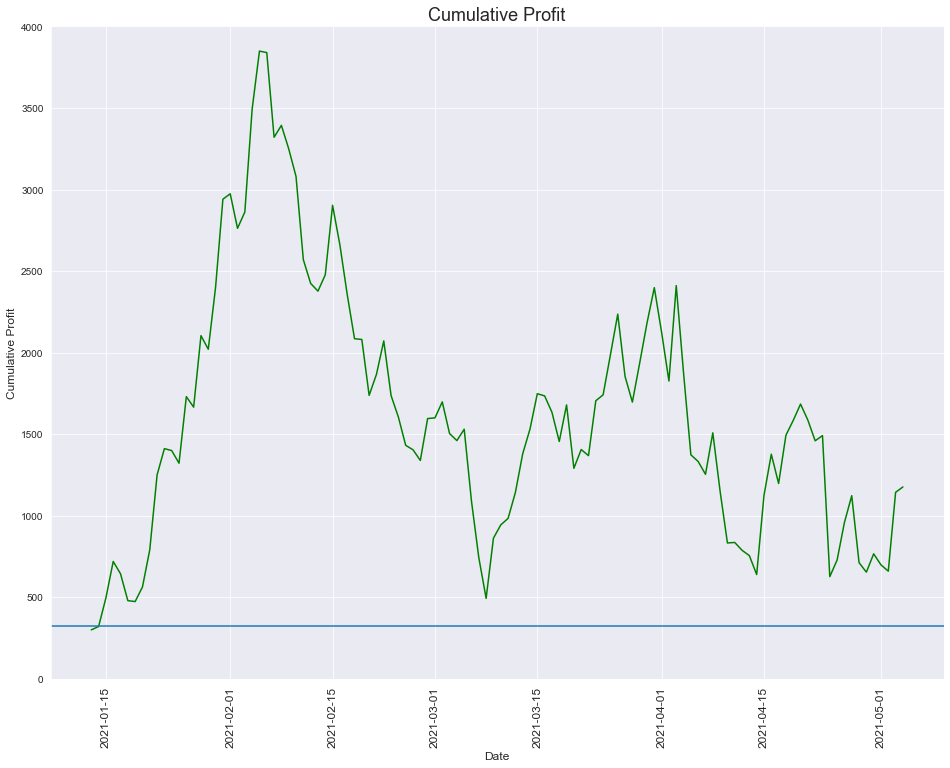

In [236]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = strat2['date'], y = strat2['Cumulative Profit'], color = 'green')
ax.set_title('Cumulative Profit', fontsize = 18)
ax.set_ylabel('Cumulative Profit', fontsize =12, )
ax.set_xlabel('Date', fontsize =12)
plt.xticks(rotation='vertical', fontsize = 12)
ax.axhline(325)
ax.set_ylim(0,4000)

plt.show()

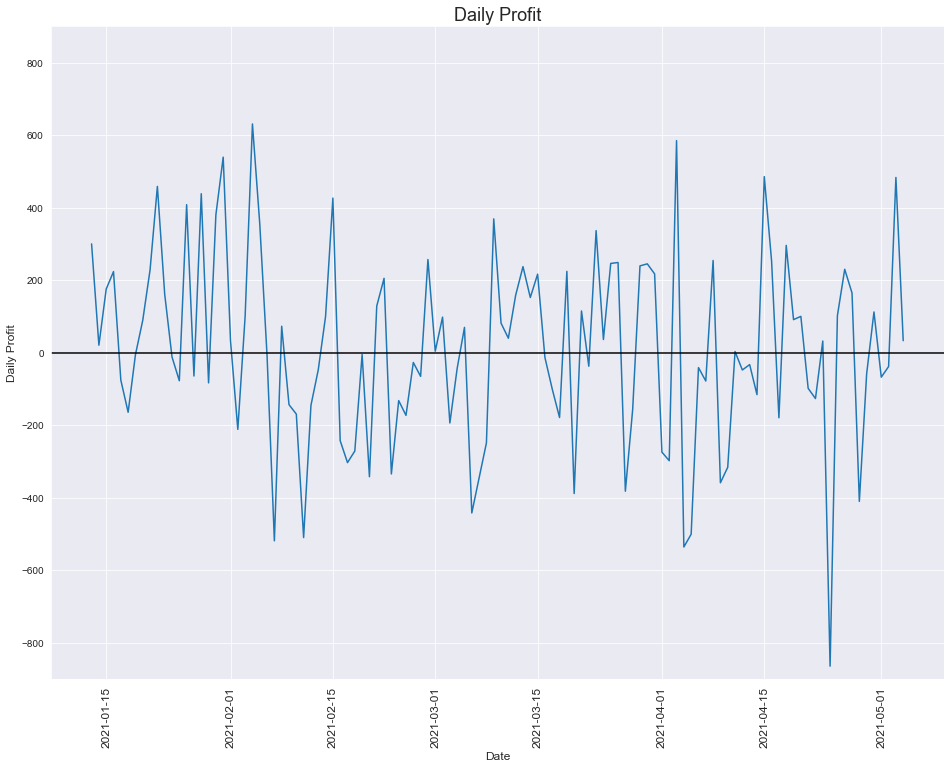

In [238]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = strat2['date'], y = strat2['Profit_Strat2'], palette = 'Blues')
ax.set_title('Daily Profit', fontsize = 18)
ax.set_ylabel('Daily Profit', fontsize =12, )
ax.set_xlabel('Date', fontsize =12)
plt.xticks(rotation='vertical', fontsize = 12)
ax.axhline(0, color = 'black')
ax.set_ylim(-900,900)
plt.show()